# Session 1: Discrete States and Actions

## Imports

In [28]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
#complete these scripts during session / as homework
from answers.environments import Gridworld
from answers.agents import MCAgent
#cross check when you finish
# from solutions.environments import Gridworld
# from solutions.agents import MCAgent

## Reinforcement Learning Framework

Reinforcement learning formulates interaction between an **agent** and its **environment** as **Markov decision processes**. For a given **state**, an agent takes an **action** based on the current **state**. In response to that action at that state, the agent will then get some **reward** from the environment, and that state changes to the next one.

$S_0 \rightarrow A_0 \rightarrow R_1 \rightarrow S_1 \rightarrow A_1 \rightarrow R_2 \rightarrow S_2 \rightarrow ... \rightarrow S_{t-1} \rightarrow A_{t-1} \rightarrow R_t \rightarrow S_{t}$

where $t$ is the last time step and $S_t$ is the **terminal state** meaning an **episode** of the interactions ended. RL problems that have an end are called **episodic tasks** and those that do not are called **continuous tasks**.

![RL Framework](img/rl_framework.png)
Source: [Sutton and Barto](https://cdn.preterhuman.net/texts/science_and_technology/artificial_intelligence/Reinforcement%20Learning%20%20An%20Introduction%20-%20Richard%20S.%20Sutton%20,%20Andrew%20G.%20Barto.pdf)

### Example

* Walking robots
    * Environment: sidewalks
    * Agent: a robot
    * States: positions, velocities and accelerations of body parts
    * Actions: move arms, legs, various joints in the body
    * Rewards: fall or not
    * Episodes: seconds, miliseconds until fall
* Ads bidding
    * Environment: Google Adwords
    * Agent: an ecommerce company
    * States: campaign impressions, clicks, purchases
    * Actions: adjust bid prices and budget
    * Rewards: conversion rates, cost of new customer acquisitions
    * Episodes: daily or hourly until campaign ends
* Retail stock trading
    * Environment: the stock market
    * Agent: a retail investor who cannot influence market prices
    * States: market prices, volumes, and other indicators
    * Actions: buy, hold, sell
    * Rewards: returns, returns adjusted by volatility, and so on
    * Episodes: daily, hourly, every second until we are extremely rich or broke
    
**In-class Assigment** Come up with one or more scenarios that you think could be framed as a reinforcement learning problem and list their elements like the example above.

## Markov Property - One-step Dynamics

One of the most fundamental assumptions of many reinforcement learning algorithms is that the interactions of the world has **Markov property**. That is, the transitions between states only depend on the current state and action, and not the history of transitions formulated as:

$$P(s_{t+1},r_{t+1}|s_t,a_t,r_t,s_{t-1},a_{t-1},...,r_1,s_0,a_0) = P(s_{t+1},r_{t+1}|s_t,a_t)$$

This can be seen as unrealistic as we intuitively use cues from a history of transitions to choose our actions in real life but as you will learn its simplicity has merits in terms of reduced complexity in real-world applications and we can incorporate long-term goals into reinforcement learning. In fact, long-term goals are one of the most important research area in reinforcement learning today.

## Environment - Gridworld

### What The Gridworld Looks Like

In [2]:
env = Gridworld()
env.print_physical(visible_only=False)


------------------------------------
['F', 'o'] |['T', 'x'] |['G', 'x'] |
------------------------------------
['F', 'x'] |['F', 'x'] |['F', 'x'] |
------------------------------------
['F', 'x'] |['F', 'x'] |['F', 'x'] |

### States

In [3]:
env.state_space

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

### Actions

In [4]:
env.action_space, env.action_text

(array([0, 1, 2, 3]), array(['U', 'L', 'D', 'R'], dtype='<U1'))

### Rewards

In [5]:
env.print_reward()


----------
0 |-5 |5 |
----------
0 |0 |0 |
----------
0 |0 |0 |

In [6]:
env.move_reward

-1

### What The Agent Usually Sees

In [7]:
env.print_physical(visible_only=True)


------------------------------------
['F', 'o'] |['NA', 'NA'] |['NA', 'NA'] |
------------------------------------
['NA', 'NA'] |['NA', 'NA'] |['NA', 'NA'] |
------------------------------------
['NA', 'NA'] |['NA', 'NA'] |['NA', 'NA'] |

In [8]:
#go down
action = np.argwhere(env.action_text=='D')
print(env.step(action))
#then right
action = np.argwhere(env.action_text=='R')
print(env.step(action))
env.print_physical(visible_only=True)

((1, 0), -1, False)
((1, 1), -1, False)

------------------------------------
['F', 'x'] |['NA', 'NA'] |['NA', 'NA'] |
------------------------------------
['F', 'x'] |['F', 'o'] |['NA', 'NA'] |
------------------------------------
['NA', 'NA'] |['NA', 'NA'] |['NA', 'NA'] |

### Deterministic Environment vs Stochastic Environment

In [9]:
env = Gridworld(wind_p=0.5)
#go down
action = np.argwhere(env.action_text=='D')
print(env.step(action))
#then right
action = np.argwhere(env.action_text=='R')
print(env.step(action))
env.print_physical(visible_only=True)

((1, 0), -1, False)
((1, 1), -1, False)

------------------------------------
['F', 'x'] |['NA', 'NA'] |['NA', 'NA'] |
------------------------------------
['F', 'x'] |['F', 'o'] |['NA', 'NA'] |
------------------------------------
['NA', 'NA'] |['NA', 'NA'] |['NA', 'NA'] |

## Agent

### Deterministic Policy

$\pi(s) \in \mathcal{A}(s)$ for all $s \in \mathcal{S}$

In [10]:
#deterministic env
env = Gridworld(wind_p=0.)
#deterministic policy
policy_a = {(0, 0): 3,
          (0, 1): 3,
          (0, 2): 0,
          (1, 0): 3,
          (1, 1): 3,
          (1, 2): 0,
          (2, 0): 3,
          (2, 1): 0,
          (2, 2): 0}
policy_b = {(0, 0): 2,
          (0, 1): 3,
          (0, 2): 0,
          (1, 0): 2,
          (1, 1): 2,
          (1, 2): 0,
          (2, 0): 3,
          (2, 1): 3,
          (2, 2): 0}

#peek
print('Reward Grid')
env.print_reward()
print('\n')
a = MCAgent(env,policy_a)
print('Policy A: Reach Goal ASAP')
a.print_policy()
print('\n')
print('Policy B: Avoid Trap')
a.policy = policy_b
a.print_policy()

Reward Grid

----------
0 |-5 |5 |
----------
0 |0 |0 |
----------
0 |0 |0 |

Policy A: Reach Goal ASAP

----------
R |R |U |
----------
R |R |U |
----------
R |U |U |

Policy B: Avoid Trap

----------
D |R |U |
----------
D |D |U |
----------
R |R |U |

### Stochastic Policy - Epsilon Greedy

$\pi(a|s) = \mathbb{P}(A_t=a|S_t=s)$ for all $s \in \mathcal{S}$ and $a \in \mathcal{A}(s)$

Preferred action for (0, 0) is 2
At epsilon 0.5, we get:


<a list of 10 Patch objects>

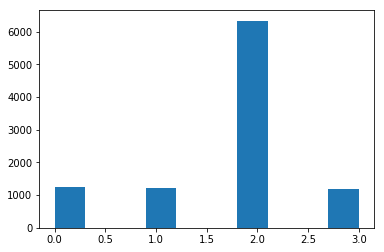

In [11]:
state = (0,0)
print(f'Preferred action for {state} is {a.policy[state]}')
print('At epsilon 0.5, we get:')
actions = np.array([a.select_action(state,epsilon=0.5) for i in range(10000)])
plt.hist(actions)[2]

In [12]:
#epsilon decaying 
a = MCAgent(env,policy_a,start_epsilon=0.9,end_epsilon=0.1,epsilon_decay=0.9)

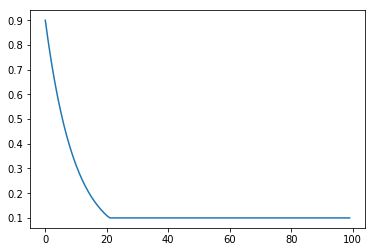

In [13]:
eps = np.array([a.get_epsilon(i) for i in range(100)])
plt.plot(eps)

### State Value

$v_\pi(s) = \sum_{a \in \mathcal{A}(s)}\pi(a|s)\sum_{s' \in \mathcal{S}, r\in\mathcal{R}}p(s',r|s,a)(r + \gamma v_\pi(s'))$

In [14]:
#deterministic env
env = Gridworld(wind_p=0.)
policy = {(0, 0): 3,
          (0, 1): 3,
          (0, 2): 0,
          (1, 0): 3,
          (1, 1): 3,
          (1, 2): 0,
          (2, 0): 3,
          (2, 1): 0,
          (2, 2): 0}
a = MCAgent(env,policy = policy, gamma = 1)
print('Reward Grid')
env.print_reward()
print('\n')
print('Policy: Reach Goal ASAP')
a.print_policy()

Reward Grid

----------
0 |-5 |5 |
----------
0 |0 |0 |
----------
0 |0 |0 |

Policy: Reach Goal ASAP

----------
R |R |U |
----------
R |R |U |
----------
R |U |U |

In [15]:
for state in env.state_space:
    a.v[state] = a.get_v(start_state=state, epsilon=0.)
a.print_v()


---------------
-2 |4 |-1 |
---------------
2 |3 |4 |
---------------
1 |2 |3 |

In [16]:
a.gamma = 0.5
for state in env.state_space:
    a.v[state] = a.get_v(start_state=state, epsilon=0.)
a.print_v()


---------------
-4.0 |4.0 |-1.0 |
---------------
-0.5 |1.0 |4.0 |
---------------
-1.2 |-0.5 |1.0 |

### (State-)Action Value

$q_\pi(s,a) = \sum_{s' \in \mathcal{S}, r\in\mathcal{R}}p(s',r|s,a)(r + \gamma\sum_{a' \in \mathcal{A}(s')} \pi(a'|s') q_\pi(s',a'))$

In [17]:
print('Reward Grid')
env.print_reward()
print('\n')
print('Policy: Reach Goal ASAP')
a.print_policy()

a.gamma=1
for state in env.state_space:
    for action in env.action_space:
        a.q[state][action] = a.get_q(state,action,epsilon=0.)

print(f'\nActions: {env.action_text}')
for i in a.q: print(i,a.q[i])

Reward Grid

----------
0 |-5 |5 |
----------
0 |0 |0 |
----------
0 |0 |0 |

Policy: Reach Goal ASAP

----------
R |R |U |
----------
R |R |U |
----------
R |U |U |
Actions: ['U' 'L' 'D' 'R']
(0, 0) [-3. -3.  1. -2.]
(0, 1) [ 3. -3.  2.  4.]
(0, 2) [-1. -2.  3. -1.]
(1, 0) [-3.  1.  0.  2.]
(1, 1) [-2.  1.  1.  3.]
(1, 2) [4. 2. 2. 3.]
(2, 0) [1. 0. 0. 1.]
(2, 1) [2. 0. 1. 2.]
(2, 2) [3. 1. 2. 2.]


### Comparing Policies

When comparing two policies a and b:

$\pi_a > \pi_b$ if and only if $v_{\pi_a}(s) > v_{\pi_b}(s)$ for all $s \in \mathcal{S}$

An optimal policy $\pi^*$ is defined as:

$\pi^* > \pi$ for all $\pi$

We can also find an optimal policy from action value function as choosing the action with the highest q-value out of any action in that state:

$\pi^*(s) = argmax_{a \in \mathcal{A}}q^*(s,a)$

In [18]:
#deterministic env
env = Gridworld(wind_p=0.)
#deterministic policy
policy_a = {(0, 0): 3,
          (0, 1): 3,
          (0, 2): 0,
          (1, 0): 3,
          (1, 1): 3,
          (1, 2): 0,
          (2, 0): 3,
          (2, 1): 0,
          (2, 2): 0}
policy_b = {(0, 0): 2,
          (0, 1): 3,
          (0, 2): 0,
          (1, 0): 2,
          (1, 1): 2,
          (1, 2): 0,
          (2, 0): 3,
          (2, 1): 3,
          (2, 2): 0}

a = MCAgent(env,policy_a)
print('Policy A: Reach Goal ASAP')
a.print_policy()
for state in env.state_space:
    a.v[state] = a.get_v(start_state=state, epsilon=0.)
a.print_v()
print('\n')
print('Policy B: Avoid Trap')
a.policy = policy_b
a.print_policy()
for state in env.state_space:
    a.v[state] = a.get_v(start_state=state, epsilon=0.)
a.print_v()

Policy A: Reach Goal ASAP

----------
R |R |U |
----------
R |R |U |
----------
R |U |U |
---------------
-2.4 |4.0 |-1.0 |
---------------
1.3 |2.6 |4.0 |
---------------
0.2 |1.3 |2.6 |

Policy B: Avoid Trap

----------
D |R |U |
----------
D |D |U |
----------
R |R |U |
---------------
-1.7 |4.0 |-1.0 |
---------------
-0.8 |0.2 |4.0 |
---------------
0.2 |1.3 |2.6 |

## Solving Reinforcement Learning Problems - Monte Carlo Methods

There are two main approaches in solving reinforcement learning: **model-based** and **model-free** approaches. A model-based approach assumes that we have some or full knowledge of how our environment works whereas a model-free approach relies on our agent to explore the environment without any prior knowledge. 

In this workshop, we will focus on model-free approaches which usually involves two steps: evalulating the state or action value function based on the agent's interactions with the environment also known as **prediction problem** and changing the agent's policy to be closer to an optimal policy also known as **control problem**.

We start with the Monte Carlo Methods aka the trial-and-error-until-you-get-rich-or-broke methods.

![Monte Carlo](img/monte_carlo.jpg)

### Prediction Problem

In [19]:
#stochastic environment
env = Gridworld(wind_p=0.2)

#initial policy
policy = {(0, 0): 3,
          (0, 1): 3,
          (0, 2): 0,
          (1, 0): 3,
          (1, 1): 3,
          (1, 2): 0,
          (2, 0): 3,
          (2, 1): 0,
          (2, 2): 0}

#stochastic agent - epsilon greedy with decays
a = MCAgent(env, policy = policy, gamma = 0.9, 
            start_epsilon=0.9,end_epsilon=0.3,epsilon_decay=0.9)

print('Reward Grid')
env.print_reward()
print('\n')
print('Policy: Reach Goal ASAP')
a.print_policy()

Reward Grid

----------
0 |-5 |5 |
----------
0 |0 |0 |
----------
0 |0 |0 |

Policy: Reach Goal ASAP

----------
R |R |U |
----------
R |R |U |
----------
R |U |U |

#### Monte Carlo State Value Prediction

![Monte Carlo State Value Prediction](img/mc_predict_v.png)

In [20]:
a.mc_predict_v()
a.print_v()


---------------
-3.3 |2.5 |0 |
---------------
-1.2 |0.6 |2.8 |
---------------
-1.4 |-0.7 |1.2 |

#### Monte Carlo Action Value Prediction

![Monte Carlo Action Value Prediction](img/mc_predict_q.png)

In [21]:
a.mc_predict_q(first_visit=False)
print(f'\nActions: {env.action_text}')
for i in a.q: print(i,a.q[i])


Actions: ['U' 'L' 'D' 'R']
(0, 0) [-3.92548758 -4.11265256 -2.09818114 -3.27472949]
(0, 1) [ 1.23316346 -4.07657872 -0.7245718   3.47291504]
(1, 0) [-3.65186239 -2.07331857 -2.42338147 -0.72149185]
(1, 1) [-3.55635392 -2.273299   -1.81391399  1.46802589]
(1, 2) [ 3.4385516  -0.64145616 -0.22891006  1.32940233]
(2, 1) [-0.81333759 -2.59115437 -1.46346686 -0.21450956]
(2, 0) [-1.53787056 -2.94343391 -2.12261564 -1.72119519]
(2, 2) [ 1.28060256 -1.41310582 -0.2860777  -1.81328304]
(0, 2) [0. 0. 0. 0.]


### Control Problem

In [22]:
#stochastic environment
env = Gridworld(wind_p=0.2)

#initial policy
policy = {(0, 0): 3,
          (0, 1): 3,
          (0, 2): 0,
          (1, 0): 3,
          (1, 1): 3,
          (1, 2): 0,
          (2, 0): 3,
          (2, 1): 0,
          (2, 2): 0}

#stochastic agent - epsilon greedy with decays
a = MCAgent(env, policy = policy, gamma = 0.9, 
            start_epsilon=0.9,end_epsilon=0.3,epsilon_decay=0.9)

print('Reward Grid')
env.print_reward()
print('\n')
print('Policy: Reach Goal ASAP')
a.print_policy()

Reward Grid

----------
0 |-5 |5 |
----------
0 |0 |0 |
----------
0 |0 |0 |

Policy: Reach Goal ASAP

----------
R |R |U |
----------
R |R |U |
----------
R |U |U |

### All-visit Monte Carlo

In [23]:
#reset
a.policy = policy
a.q = defaultdict(lambda: np.zeros(a.n_action))
a.n_q = defaultdict(lambda: np.zeros(a.n_action))

a.mc_control_q(n_episode = 1000,first_visit=False)
a.print_policy()
print(f'\nActions: {env.action_text}')
for i in a.q: print(i,a.q[i])


----------
D |R |U |
----------
R |R |U |
----------
U |R |U |
Actions: ['U' 'L' 'D' 'R']
(0, 0) [-4.27943992 -4.1694849  -1.82026869 -3.46063774]
(0, 1) [ 0.72613205 -3.75420578 -1.08463263  3.33063217]
(1, 0) [-5.27368466 -3.87197983 -2.82267803 -0.38238763]
(2, 0) [-1.819      -3.88739917 -2.284264   -2.85094324]
(1, 1) [-2.736567   -1.71104392 -0.83779866  1.16551644]
(2, 1) [-0.27713217 -3.3598306  -1.56047681  1.1132    ]
(2, 2) [ 1.98411 -0.1342  -0.8146   1.382  ]
(1, 2) [ 3.28297101 -0.69254731  0.14711652  0.47764164]
(0, 2) [0. 0. 0. 0.]


#### First-visit Monte Carlo

In [24]:
#reset
a.policy = policy
a.q = defaultdict(lambda: np.zeros(a.n_action))
a.n_q = defaultdict(lambda: np.zeros(a.n_action))

a.mc_control_q(n_episode = 1000,first_visit=True)
a.print_policy()
print(f'\nActions: {env.action_text}')
for i in a.q: print(i,a.q[i])


----------
D |R |U |
----------
R |R |U |
----------
R |R |U |
Actions: ['U' 'L' 'D' 'R']
(0, 0) [-3.2318982  -3.47624847 -2.09759588 -4.0182079 ]
(1, 0) [-3.32075267 -2.05323159 -2.96992952 -0.73489268]
(0, 1) [ 0.95185514 -3.29976464 -0.13602162  3.41909399]
(1, 1) [-3.38040113 -2.06830689 -1.8638852   1.36671122]
(1, 2) [ 3.30167142 -0.44401267  0.00600392  1.28666622]
(2, 1) [-1.48348326 -3.59143396 -2.35621499 -0.56584758]
(2, 0) [-2.15350849 -2.24515034 -3.99656203 -1.88593353]
(2, 2) [ 1.08291197 -1.42388726 -0.17114539 -0.90637   ]
(0, 2) [0. 0. 0. 0.]


#### Greedy within The Limit of Exploration 

![Greedy within The Limit of Exploration](img/mc_control_glie.png)

In [25]:
#reset
a.policy = policy
a.q = defaultdict(lambda: np.zeros(a.n_action))
a.n_q = defaultdict(lambda: np.zeros(a.n_action))

a.mc_control_glie(n_episode = 1000)
a.print_policy()
print(f'\nActions: {env.action_text}')
for i in a.q: print(i,a.q[i])


----------
D |R |U |
----------
R |R |U |
----------
R |R |U |
Actions: ['U' 'L' 'D' 'R']
(0, 0) [-3.30292981 -3.25992486 -1.86843291 -3.14312549]
(0, 1) [ 1.7194625  -2.70555105  0.22145442  3.34531047]
(0, 2) [0. 0. 0. 0.]
(1, 0) [-3.19959762 -2.23694056 -2.68500401 -0.4625063 ]
(1, 1) [-3.50788219 -2.01663073 -1.25375229  1.45030324]
(1, 2) [ 3.53148384 -0.48600386  0.14555885  1.41663129]
(2, 0) [-2.59606855 -2.54412744 -3.06966766 -1.33786136]
(2, 1) [-1.16641857 -2.72133419 -1.94436006 -0.15517614]
(2, 2) [ 1.52923063e+00 -1.29125683e+00 -3.30688882e-01 -8.32294728e-04]


#### GLIE with Constant Learning Rate

![GLIE with constant learning rate](img/mc_control_glie_constant.png)

In [26]:
#reset
a.policy = policy
a.q = defaultdict(lambda: np.zeros(a.n_action))
a.n_q = defaultdict(lambda: np.zeros(a.n_action))

a.mc_control_glie(n_episode = 1000, lr=0.1)
a.print_policy()
print(f'\nActions: {env.action_text}')
for i in a.q: print(i,a.q[i])


----------
D |R |U |
----------
R |R |U |
----------
R |R |U |
Actions: ['U' 'L' 'D' 'R']
(0, 0) [-3.88867934 -3.93522798 -2.27093115 -3.46644497]
(0, 1) [ 0.91693494 -3.35356981  0.20819916  3.64295331]
(0, 2) [0. 0. 0. 0.]
(1, 0) [-3.50044857 -2.58718687 -2.12838722 -1.23485409]
(1, 1) [-2.71399151 -1.33847698 -1.38454913  1.41876372]
(1, 2) [ 3.29462048 -0.47355178  0.27500137  1.98788302]
(2, 0) [-3.30801607 -2.58012599 -2.56456827 -0.967357  ]
(2, 1) [-0.82280348 -2.11157697 -1.2067364   0.34774965]
(2, 2) [ 1.83368481 -1.30583741 -0.42572958  0.23465617]


## Challenges

* What are some other ways of solving reinforcement learning problems? How are they better or worse than Monte Carlo methods e.g. performance, data requirements, etc.?
* Play around with Gridworld. Tweak these variables and see what happens:
    * Wing probability
    * Move rewards
    * Discount factor
    * Epsilon and how to decay it (or not)
* Solve at least one of the following OpenAI gym environments with discrete states and actions:
    * FrozenLake-v0
    * Taxi-v2
    * Blackjack-v0